<b> Problem Stament </b>
    
   To build a predictive model to identify patterns in the given variables that suggest that a hack is going to happen. 
  
  <b> Data </b>
    
The train and test data will consist of the various features that will help to predict if a hack is going to happen or not.
The variables present are:

* INCIDENT_ID: Unique identifier for incident log
* DATE: Date wof occurence
* X_1- X_15: Anonymized logging partners

The parameter to be predicted:
* MULTIPLE_OFFENSE: Indicates if the incident was a hack(1: Yes, 0: No)    

# Import packages and data

In [367]:
import numpy as np
import pandas as pd
import seaborn as sns
import datetime
import math
from collections import Counter
from scipy.stats import entropy
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
filepath= r'F:\Data Science\Projects\Novartis_HE\Dataset'

In [3]:
train_df= pd.read_csv(f'{filepath}\Train.csv')
test_df= pd.read_csv(f'{filepath}\Test.csv')
subms_df= pd.read_csv(f'{filepath}\sample_submission.csv')

 # Pre-processing
  Exploration and Insight generation

In [4]:
# View the data
train_df.head()

,INCIDENT_ID,DATE,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,X_10,X_11,X_12,X_13,X_14,X_15,MULTIPLE_OFFENSE
0,CR_102659,04-JUL-04,0,36,34,2,1,5,6,1,6,1,174,1.0,92,29,36,0
1,CR_189752,18-JUL-17,1,37,37,0,0,11,17,1,6,1,236,1.0,103,142,34,1
2,CR_184637,15-MAR-17,0,3,2,3,5,1,0,2,3,1,174,1.0,110,93,34,1
3,CR_139071,13-FEB-09,0,33,32,2,1,7,1,1,6,1,249,1.0,72,29,34,1
4,CR_109335,13-APR-05,0,33,32,2,1,8,3,0,5,1,174,0.0,112,29,43,1


In [ ]:
train_org= train_df.copy(deep= True) # deep copy to save the original dataframe

In [5]:
print("Shape of the training data: ",train_df.shape )

Shape of the training data:  (23856, 18)


In [6]:
print(" Information of Data columns: ")
train_df.info()

 Information of Data columns: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23856 entries, 0 to 23855
Data columns (total 18 columns):
INCIDENT_ID         23856 non-null object
DATE                23856 non-null object
X_1                 23856 non-null int64
X_2                 23856 non-null int64
X_3                 23856 non-null int64
X_4                 23856 non-null int64
X_5                 23856 non-null int64
X_6                 23856 non-null int64
X_7                 23856 non-null int64
X_8                 23856 non-null int64
X_9                 23856 non-null int64
X_10                23856 non-null int64
X_11                23856 non-null int64
X_12                23674 non-null float64
X_13                23856 non-null int64
X_14                23856 non-null int64
X_15                23856 non-null int64
MULTIPLE_OFFENSE    23856 non-null int64
dtypes: float64(1), int64(15), object(2)
memory usage: 3.3+ MB


In [53]:
print(" Missing values in training set: ")
train_df.isnull().sum()/ len(train_df)

 Missing values in training set: 


INCIDENT_ID         0.000000
DATE                0.000000
X_1                 0.000000
X_2                 0.000000
X_3                 0.000000
X_4                 0.000000
X_5                 0.000000
X_6                 0.000000
X_7                 0.000000
X_8                 0.000000
X_9                 0.000000
X_10                0.000000
X_11                0.000000
X_12                0.007629
X_13                0.000000
X_14                0.000000
X_15                0.000000
MULTIPLE_OFFENSE    0.000000
dtype: float64

Only column X_12 has has missing values. We will be looking into it if we can impute values in the missing cells.

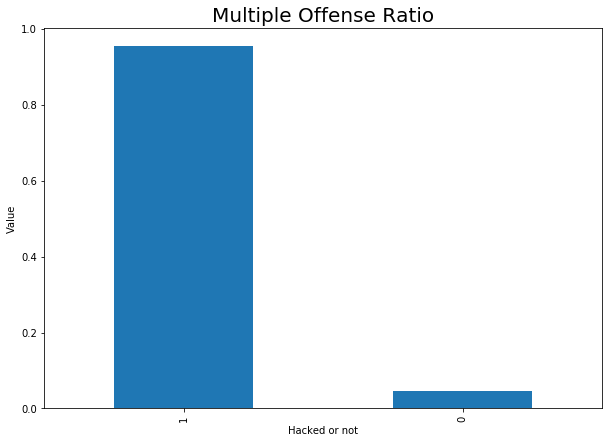

Multiple Offense distribution 
 1    22788
0     1068
Name: MULTIPLE_OFFENSE, dtype: int64


In [8]:
plt.figure(figsize= (10, 7))
plt.title("Multiple Offense Ratio", fontdict= {'fontsize': 20})
plt.xlabel("Hacked or not")
plt.ylabel("Value")
(train_df.MULTIPLE_OFFENSE.value_counts()/ len(train_df)).plot(kind= 'bar' )
plt.show()

print("Multiple Offense distribution \n", train_df.MULTIPLE_OFFENSE.value_counts())

From the above plot, we see that the data is highly imbalanced wrt the target variable. This needs to be handled before we plot the data.

In [355]:
for feature in train_df.columns:
    uniq = np.unique(train_df[feature])
    print('{}: {} distinct values -  {}'.format(feature,len(uniq),uniq))

INCIDENT_ID: 23856 distinct values -  ['CR_100' 'CR_100008' 'CR_10001' ... 'CR_99954' 'CR_99962' 'CR_99970']
DATE: 9121 distinct values -  ['01-APR-00' '01-APR-01' '01-APR-02' ... '31-OCT-97' '31-OCT-98'
 '31-OCT-99']
X_1: 8 distinct values -  [0 1 2 3 4 5 6 7]
X_2: 52 distinct values -  [ 0  1  2  3  4  5  6  7  8  9 10 11 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52]
X_3: 52 distinct values -  [ 0  1  2  3  4  5  6  7  8  9 10 11 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52]
X_4: 10 distinct values -  [ 0  1  2  3  4  5  6  7  9 10]
X_5: 5 distinct values -  [0 1 2 3 5]
X_6: 19 distinct values -  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
X_7: 19 distinct values -  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18]
X_8: 24 distinct values -  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 20 21 22 29 30 5

INCIDENT_ID
['CR_102659' 'CR_189752' 'CR_184637' ... 'CR_157556' 'CR_103180'
 'CR_22575']
DATE
['04-JUL-04' '18-JUL-17' '15-MAR-17' ... '14-SEP-14' '01-MAY-14'
 '08-NOV-94']


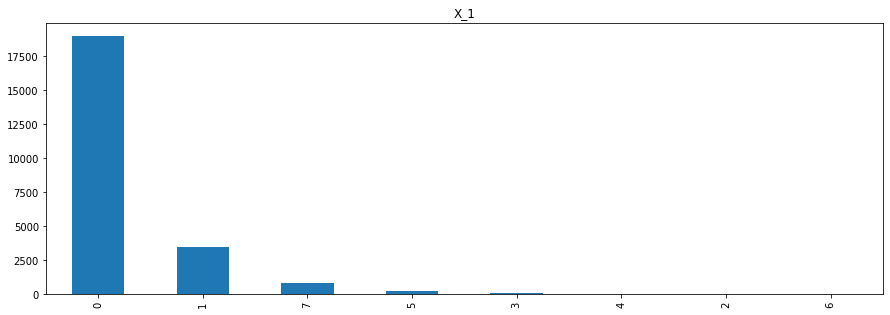

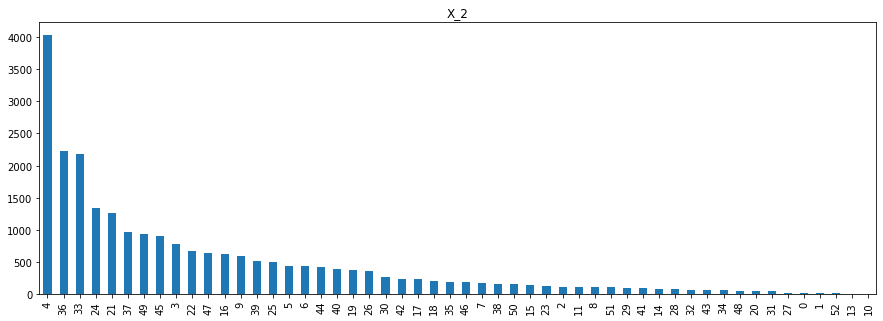

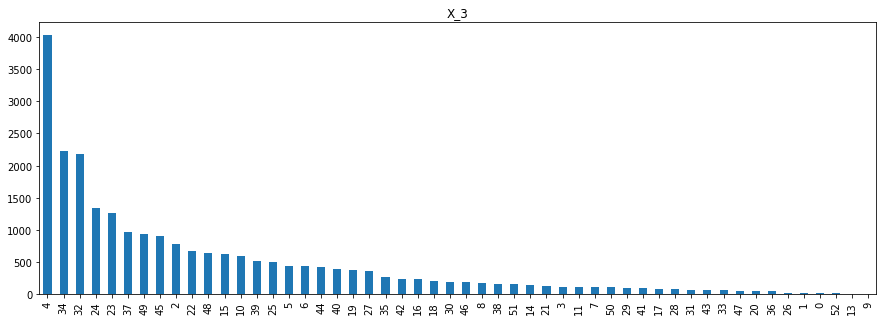

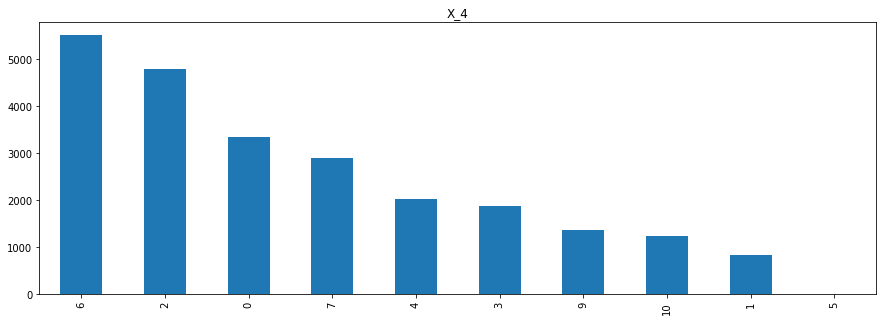

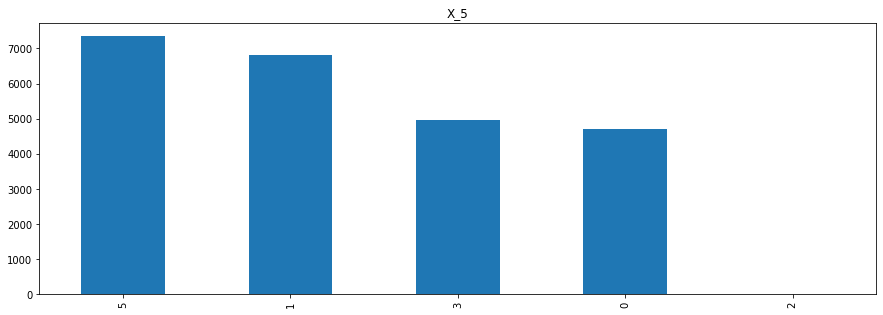

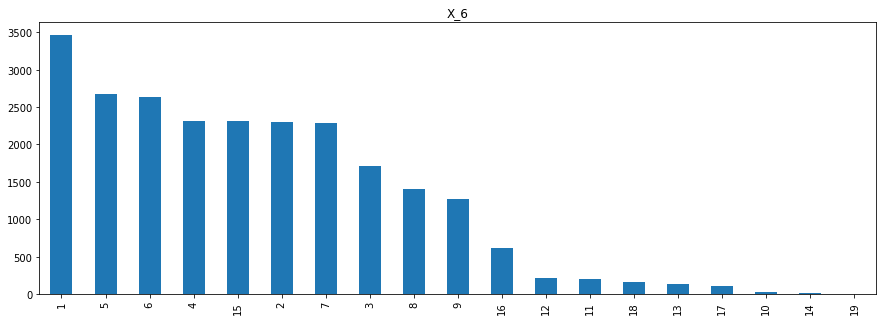

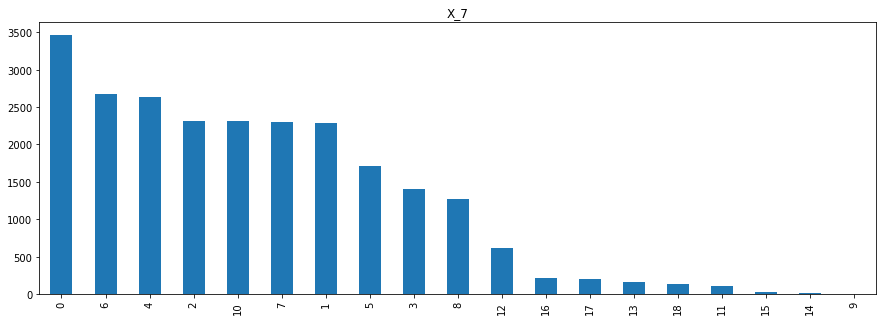

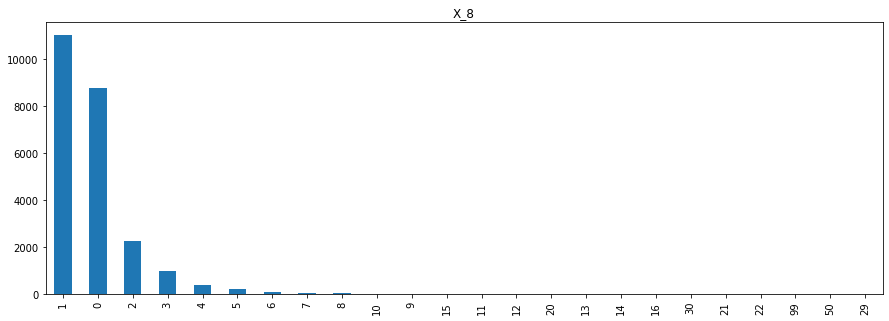

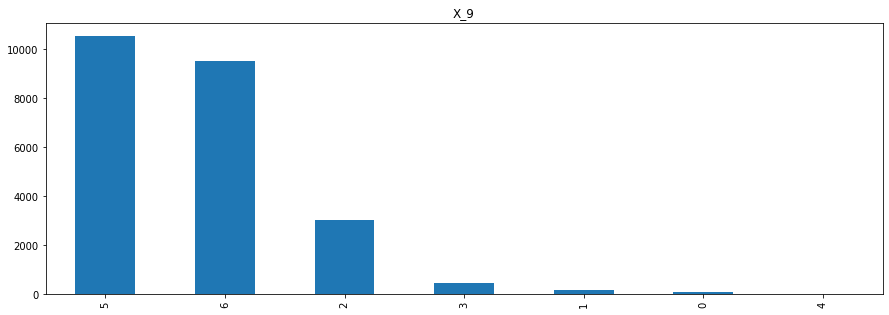

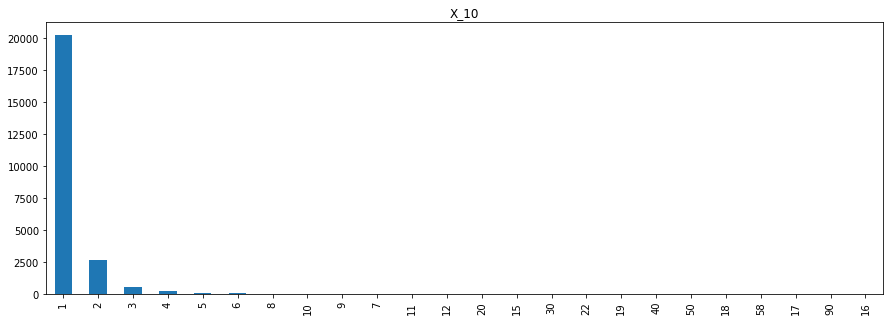

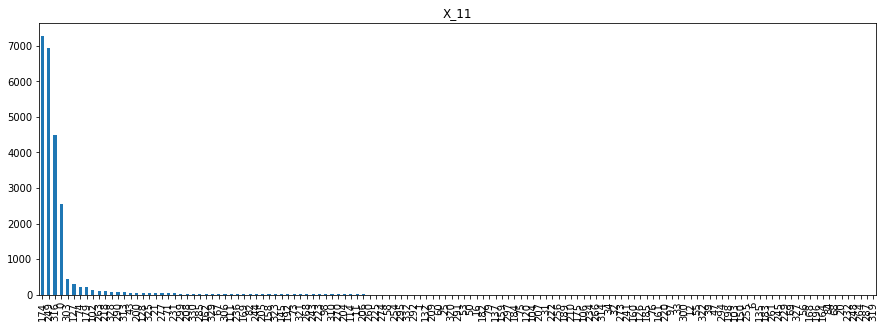

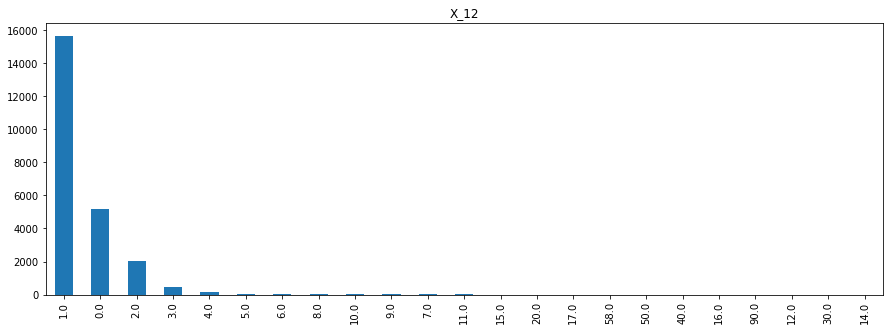

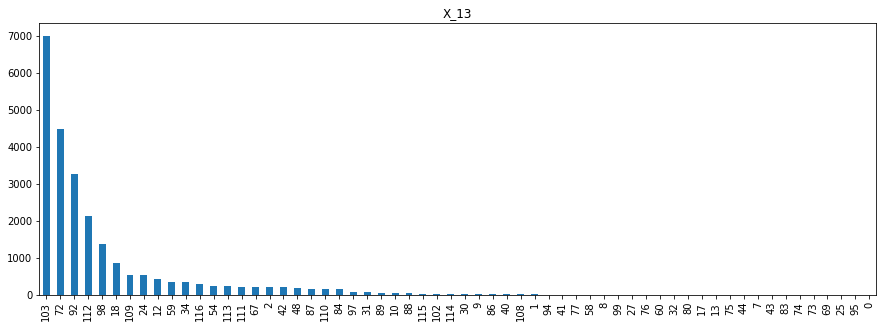

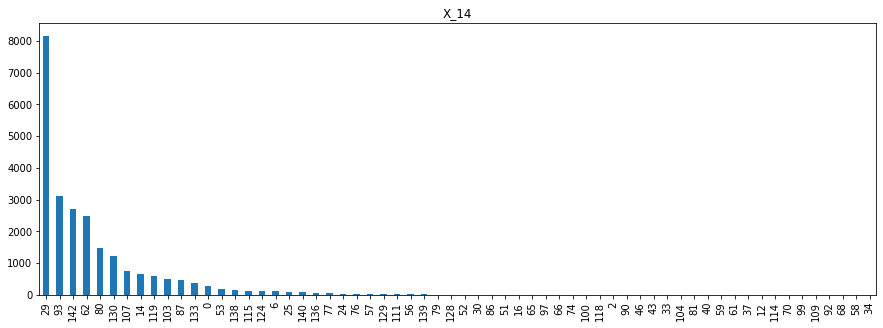

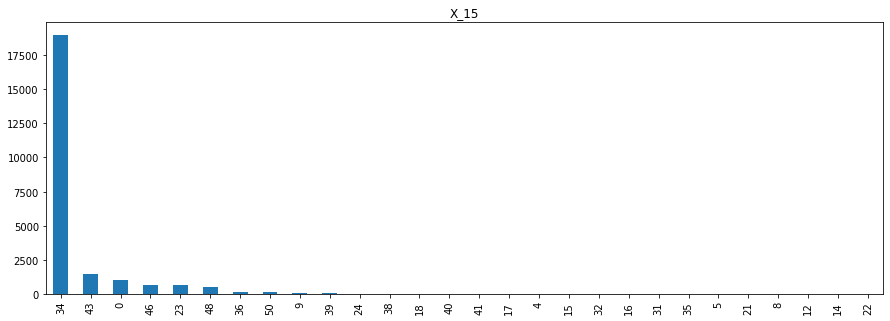

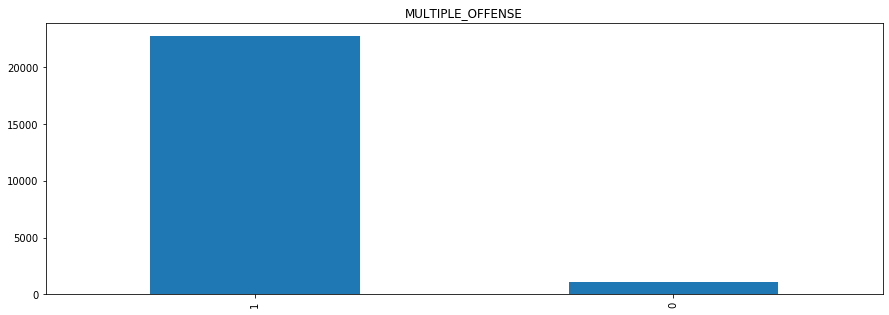

In [51]:
# to print the count of unique values in each columns
# df_dict = dict(zip([i for i in train_df.columns] , [pd.DataFrame(train_df[i].unique(), columns=[i]) for i in train_df.columns]))
#train_df.iloc(2:).plot(subplots= True, layout= (3, 5), kind= 'bar');
for col in list(train_df):
    #print(col)
    #print(train_df[col].unique())
    
    if(train_df[col].dtype== 'object'):
        print(col)
        print(train_df[col].unique())        
    else:
        plt.figure()
        col_val= train_df[col].value_counts() 
        col_val.plot(kind= 'bar', title= col, figsize= (15, 5))
        #print(col_val)

From the unique values above, we see that, even though 'X_12' is listed as a float column, none of the input in the column are of type float. So the pattern of the logging partners are no different. 

We also get an idea of the spread of the various values for each column.

Also, we from the plotting of the X-values that they are concentrated on a few of the values, and most are rightly skewed.

In [201]:
# to form a a dataframe of value counts
s= pd.DataFrame()
for i in list(train_df)[2: 16]:
    x= pd.DataFrame(train_df[i].value_counts() )
    #print(x)
    s= pd.concat([s, x], axis= 1)

In [56]:
# to see which category do the missing values belong to
train_df[train_df.X_12.isnull()].MULTIPLE_OFFENSE.value_counts()

1    182
Name: MULTIPLE_OFFENSE, dtype: int64

Now, the missing value in X_12 needs to be handled. It can be done either by removing the missing value rows, or bu imputing for the missing value.

* As the missing value is less than 1%, we can remove the rows having missing values also. Also, since the missing values belong to "Hacked" category, there won't be much loss of data, as about 95% of our data belong to "Hacked" class.
* But instead of losing data, we imputed value for missing row. Seeing the spread of data, mode is a good option for imputation.

In [62]:
# imputing missing values
train_df.X_12.fillna(train_df.X_12.mode()[0], inplace= True)

In [73]:
# Descriptive Statistics of the columns
train_df.describe(include= 'all')

,INCIDENT_ID,DATE,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,X_10,X_11,X_12,X_13,X_14,X_15,MULTIPLE_OFFENSE
count,23856,23856,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000
unique,23856,9121,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,CR_31286,12-SEP-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,0.483778,24.791206,24.637450,4.276744,2.455609,6.154175,4.876509,0.972460,4.924128,1.244802,206.954519,0.974262,85.237383,72.674296,33.464747,0.955231
std,NaN,NaN,1.439738,15.240231,15.135093,2.944672,1.963095,4.471756,3.881931,1.453144,1.362625,1.119301,93.033348,1.163264,27.597226,43.297320,8.386834,0.206800
min,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,NaN,NaN,0.000000,7.000000,8.000000,2.000000,1.000000,3.000000,2.000000,0.000000,5.000000,1.000000,174.000000,1.000000,72.000000,29.000000,34.000000,1.000000
50%,NaN,NaN,0.000000,24.000000,24.000000,4.000000,3.000000,5.000000,4.000000,1.000000,5.000000,1.000000,249.000000,1.000000,98.000000,62.000000,34.000000,1.000000
75%,NaN,NaN,0.000000,36.000000,35.000000,6.000000,5.000000,8.000000,7.000000,1.000000,6.000000,1.000000,249.000000,1.000000,103.000000,107.000000,34.000000,1.000000


Visulaising X_1 to X_15 wrt MULTIPLE_OFFENSE

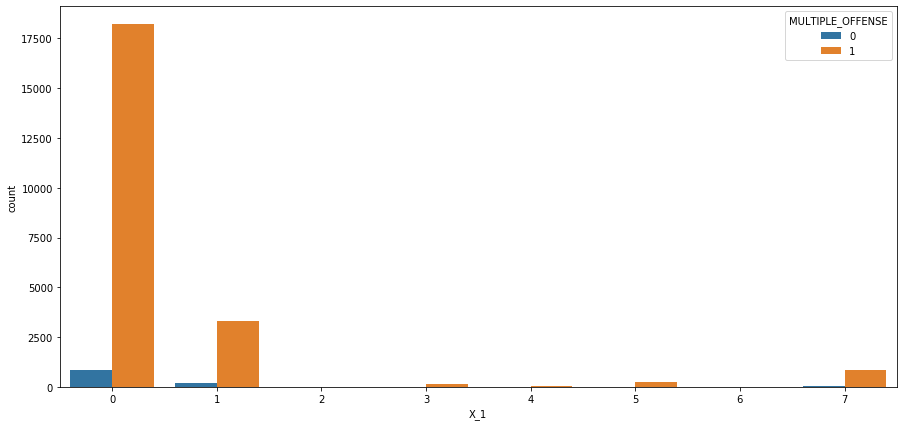

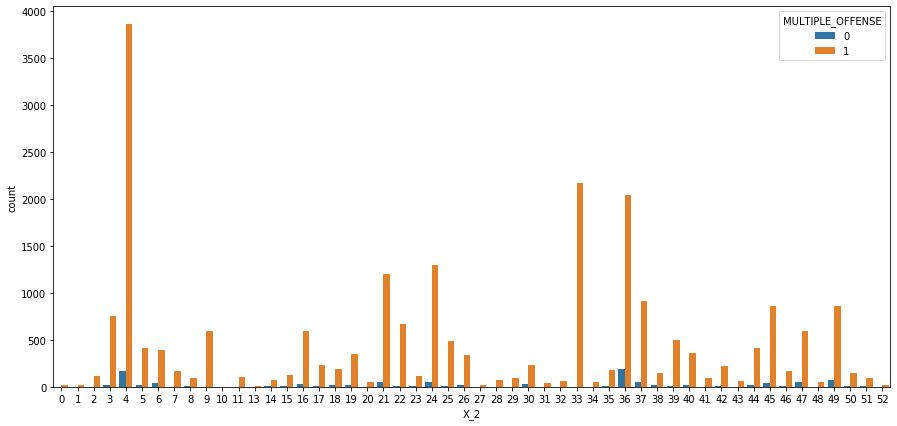

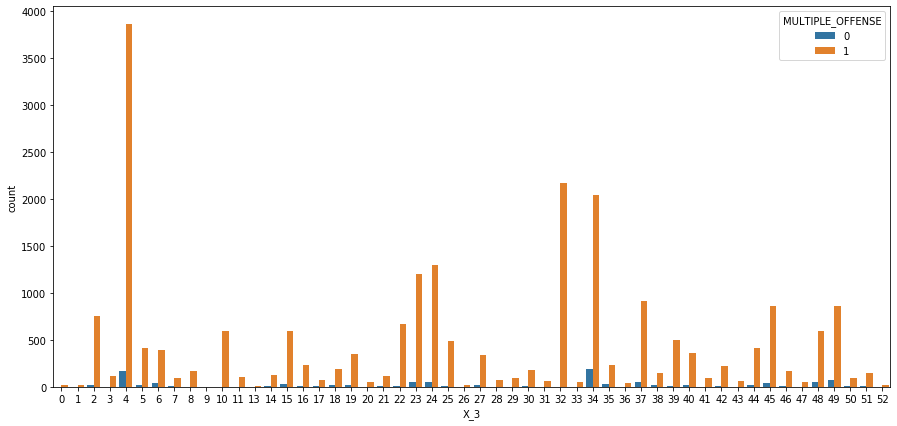

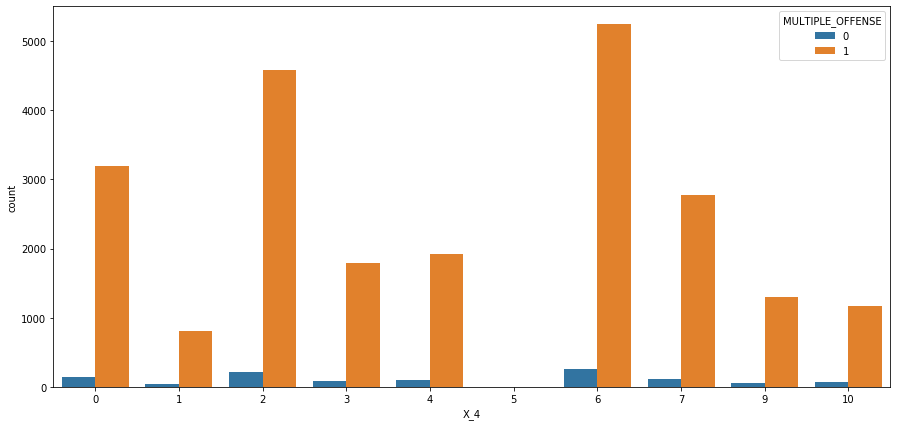

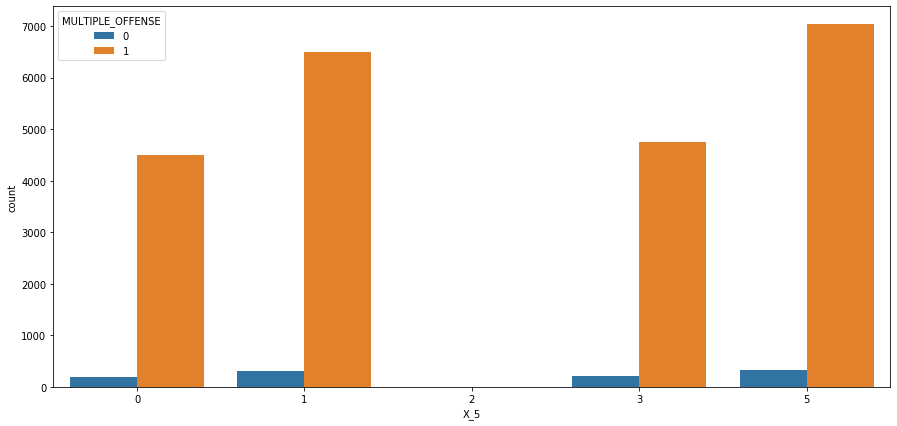

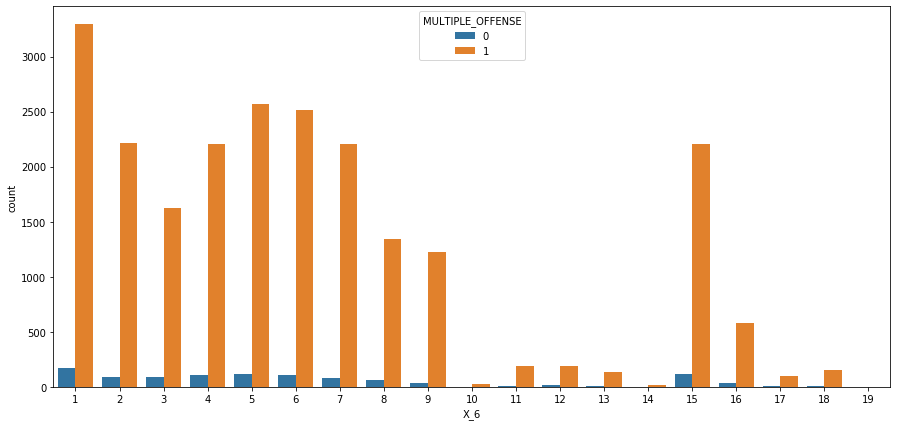

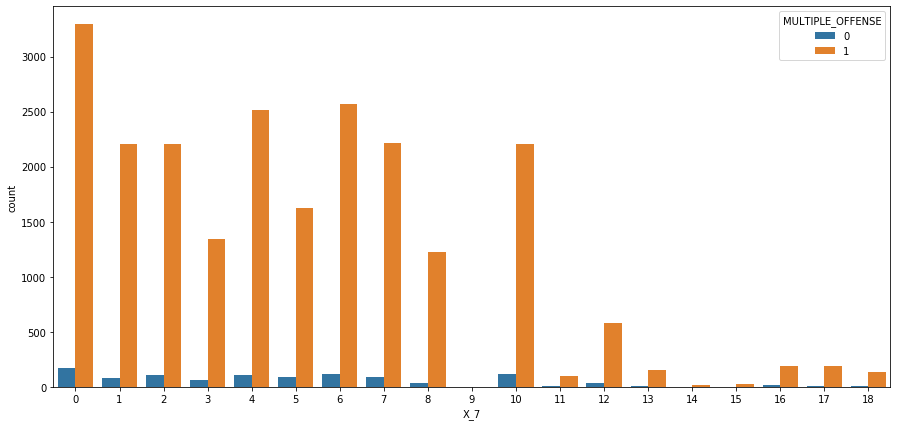

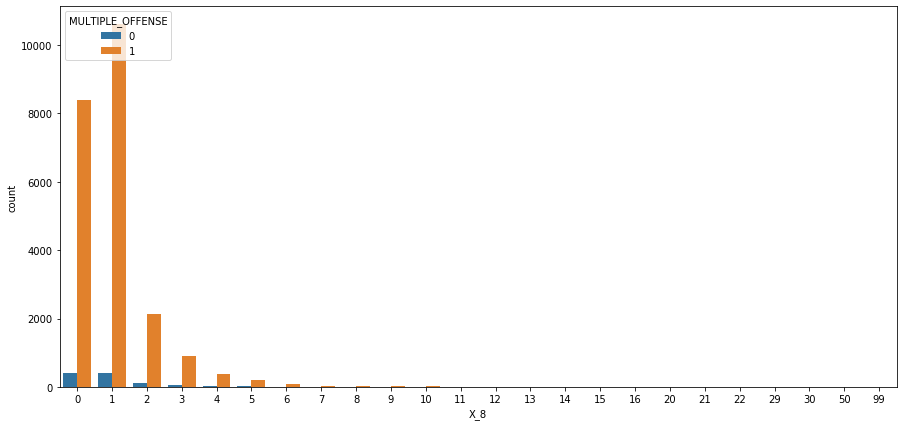

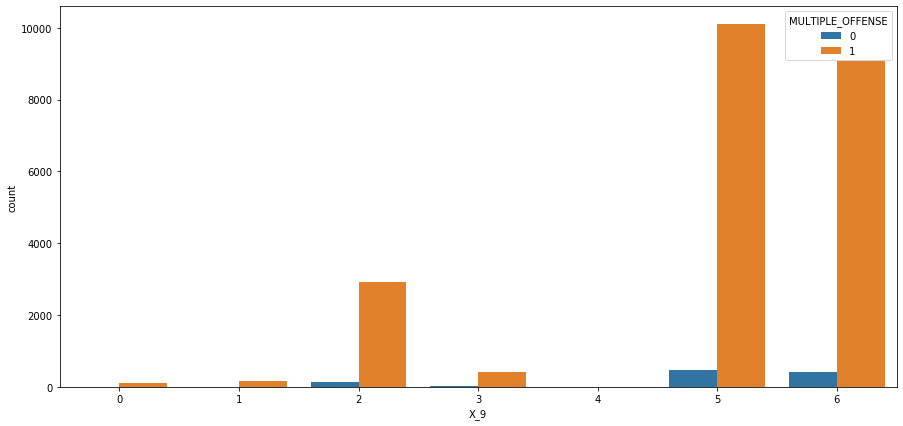

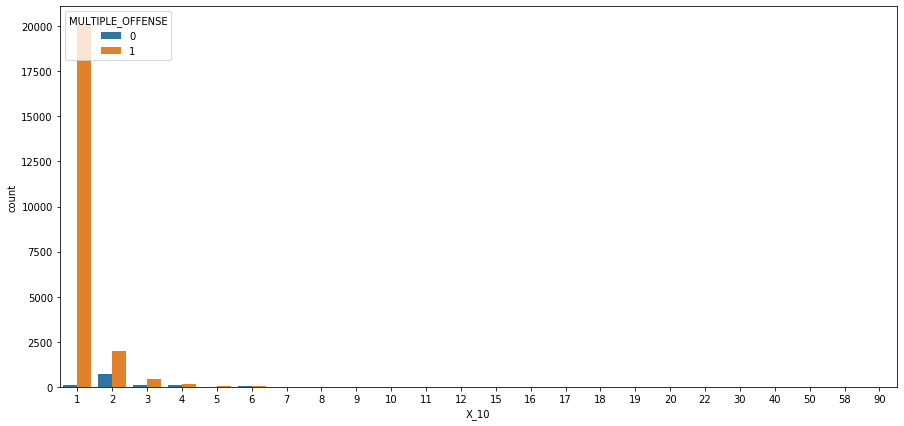

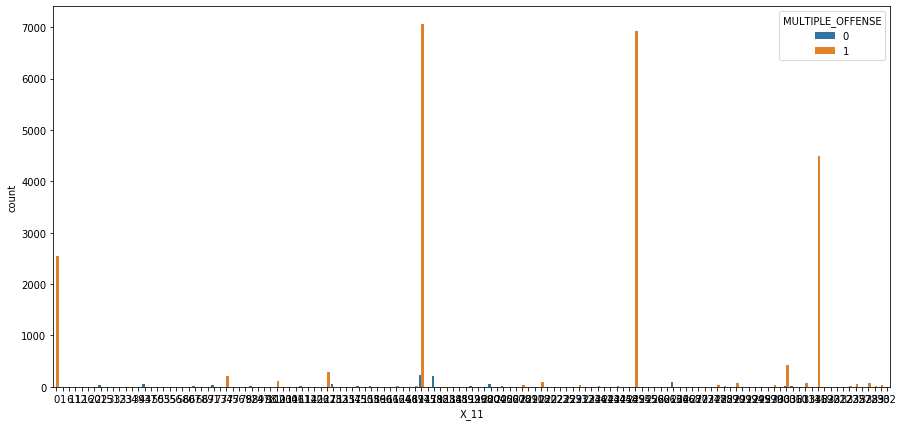

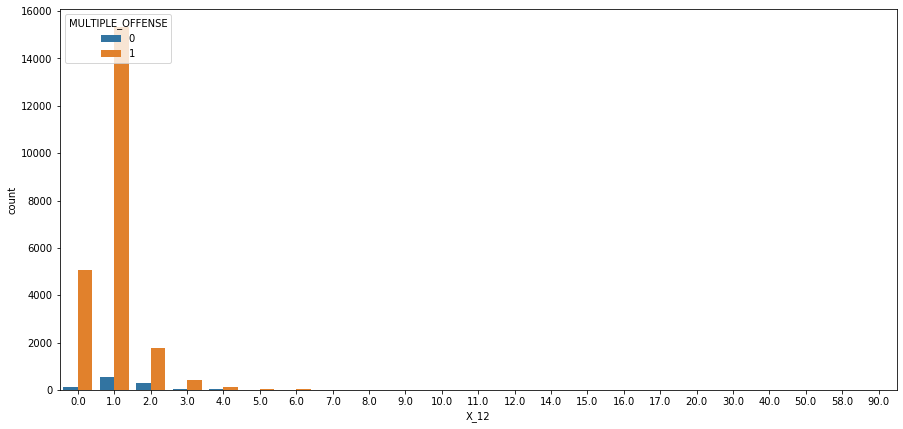

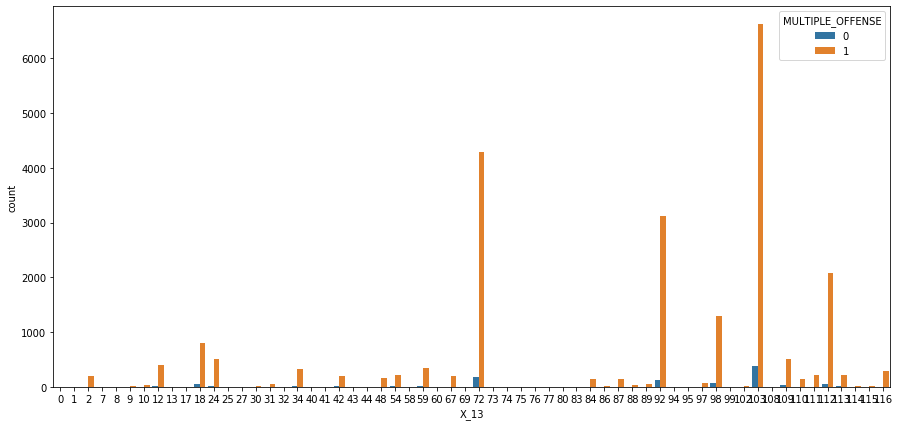

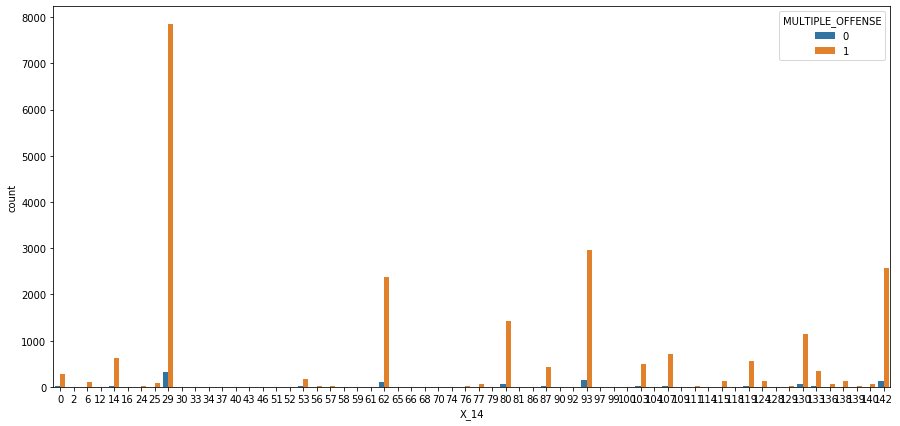

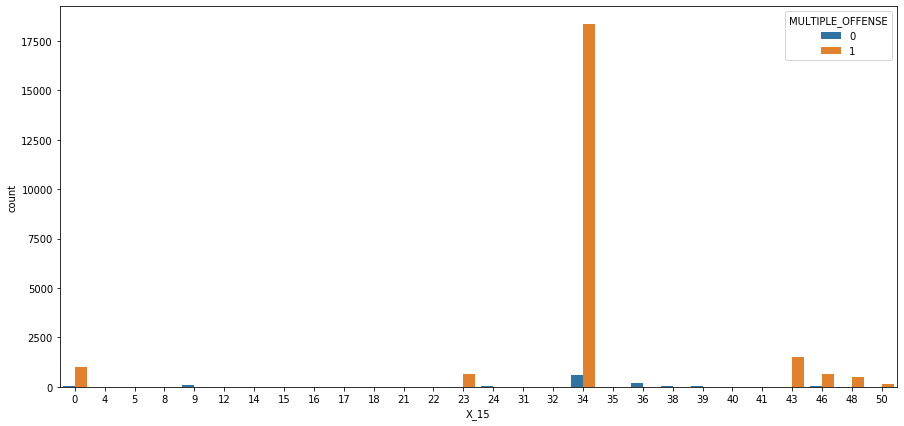

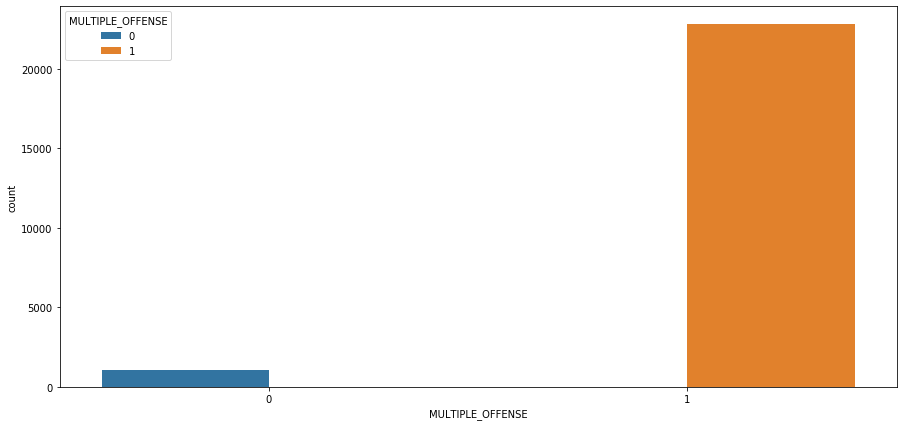

In [92]:
for col in list(train_df)[2:]:
    plt.figure(figsize= (15, 7))
    sns.countplot(data= train_df, x= col, hue= 'MULTIPLE_OFFENSE')

Working on the Date column

In [120]:
train_df["Year"]= pd.DatetimeIndex(train_df.DATE).year
train_df["Month"]= pd.DatetimeIndex(train_df.DATE).month
train_df.head(3)

,INCIDENT_ID,DATE,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,X_10,X_11,X_12,X_13,X_14,X_15,MULTIPLE_OFFENSE,Year,Month
0,CR_102659,04-JUL-04,0,36,34,2,1,5,6,1,6,1,174,1.0,92,29,36,0,2004,7
1,CR_189752,18-JUL-17,1,37,37,0,0,11,17,1,6,1,236,1.0,103,142,34,1,2017,7
2,CR_184637,15-MAR-17,0,3,2,3,5,1,0,2,3,1,174,1.0,110,93,34,1,2017,3


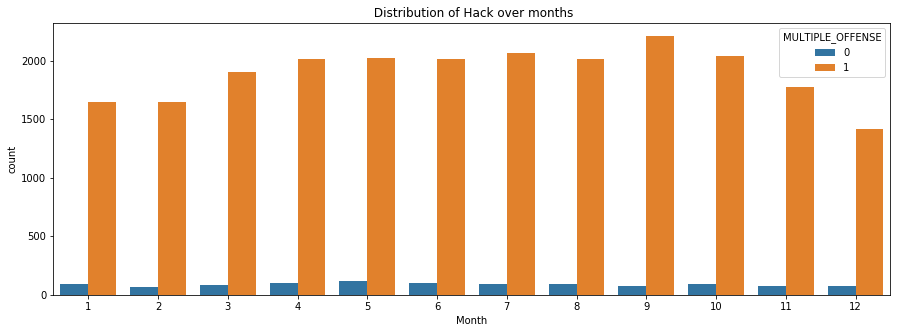

In [139]:
plt.figure(figsize= (15, 5))
plt.title(" Distribution of Hack over months");
sns.countplot(data= train_df, x= 'Month', hue= 'MULTIPLE_OFFENSE');

From above, we see that, the spread of the hacks is almost unifor over the months, with a slight peak in the 10th, ie, October month.

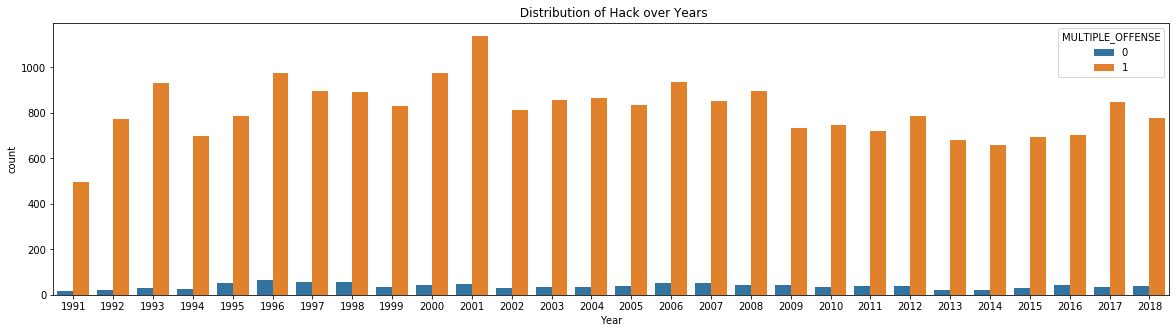

In [141]:
plt.figure(figsize= (20, 5))
plt.title(" Distribution of Hack over Years");
sns.countplot(data= train_df, x= 'Year', hue= 'MULTIPLE_OFFENSE');

From above, we see that, over years, the hacks have seen a spike in the year 2001, with a gradual decrease.

We have seen that the X_1 to X_15 values are skewed, as well as, the ranges vary widely for different parameters. 

In [148]:
train_df.head(5)

,INCIDENT_ID,DATE,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,X_10,X_11,X_12,X_13,X_14,X_15,MULTIPLE_OFFENSE,Year,Month
0,CR_102659,04-JUL-04,0,36,34,2,1,5,6,1,6,1,174,1.0,92,29,36,0,2004,7
1,CR_189752,18-JUL-17,1,37,37,0,0,11,17,1,6,1,236,1.0,103,142,34,1,2017,7
2,CR_184637,15-MAR-17,0,3,2,3,5,1,0,2,3,1,174,1.0,110,93,34,1,2017,3
3,CR_139071,13-FEB-09,0,33,32,2,1,7,1,1,6,1,249,1.0,72,29,34,1,2009,2
4,CR_109335,13-APR-05,0,33,32,2,1,8,3,0,5,1,174,0.0,112,29,43,1,2005,4


In [370]:
# Theil's U for correlation between categorical variables
# Ref: https://towardsdatascience.com/the-search-for-categorical-correlation-a1cf7f1888c9
def conditional_entropy(x,y):
    # entropy of x given y
    y_counter = Counter(y)
    xy_counter = Counter(list(zip(x,y)))
    total_occurrences = sum(y_counter.values())
    entropy = 0
    for xy in xy_counter.keys():
        p_xy = xy_counter[xy] / total_occurrences
        p_y = y_counter[xy[1]] / total_occurrences
        entropy += p_xy * math.log(p_y/p_xy)
    return entropy

def theil_u(x,y):
    s_xy = conditional_entropy(x,y)
    x_counter = Counter(x)
    total_occurrences = sum(x_counter.values())
    p_x = list(map(lambda n: n/total_occurrences, x_counter.values()))
    s_x = entropy(p_x)
    if s_x == 0:
        return 1
    else:
        return (s_x - s_xy) / s_x    

In [398]:
theilu = pd.DataFrame(index=train_df.columns[2: 17],columns= train_df.columns[2: 17])
columns = list(theilu.columns)
for row in columns:   
    for col in columns:
        u = theil_u(train_df[row].tolist(),train_df[col].tolist())
        theilu.loc[row, col] = u
theilu.fillna(value=np.nan,inplace=True)


,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,X_10,X_11,X_12,X_13,X_14,X_15
X_1,1,0.170713,0.170713,0.0791942,0.0469437,0.891893,0.891893,0.014012,0.0166746,0.00358805,0.0334036,0.0100265,0.101581,0.0230243,0.0241832
X_2,0.0357833,1,1,0.631851,0.424583,0.171957,0.171957,0.0193205,0.0173574,0.00721869,0.0465741,0.019111,0.0745298,0.0500508,0.0393724
X_3,0.0357833,1,1,0.631851,0.424583,0.171957,0.171957,0.0193205,0.0173574,0.00721869,0.0465741,0.019111,0.0745298,0.0500508,0.0393724
X_4,0.026272,1,1,1,0.671967,0.115307,0.115307,0.0153275,0.0157807,0.00506383,0.0327191,0.015207,0.0608577,0.0421483,0.0391489
X_5,0.0231754,1,1,1,1,0.0784839,0.0784839,0.0171807,0.0174131,0.00400851,0.0300318,0.0166129,0.0644703,0.0458148,0.0417074
X_6,0.244721,0.225095,0.225095,0.0953709,0.0436203,1,1,0.0086309,0.010414,0.00267877,0.0284396,0.00949048,0.0422073,0.02495,0.0165297
X_7,0.244721,0.225095,0.225095,0.0953709,0.0436203,1,1,0.0086309,0.010414,0.00267877,0.0284396,0.00949048,0.0422073,0.02495,0.0165297
X_8,0.0075582,0.0497192,0.0497192,0.0249225,0.0187719,0.0169674,0.0169674,1,0.345533,0.0149704,0.163545,0.0579467,0.0533774,0.046601,0.0661142
X_9,0.00997894,0.0495564,0.0495564,0.0284679,0.0211083,0.0227136,0.0227136,0.383353,1,0.00810096,0.195643,0.0602628,0.0568916,0.122202,0.0805902
X_10,0.00424268,0.0407218,0.0407218,0.0180494,0.00960094,0.011544,0.011544,0.0328168,0.0160062,1,0.157966,0.667906,0.0309776,0.0251876,0.0589486


From above, we see that the follow correlations exist:
* X_1 explains X_6 and X_7
* X_2 explains X_3, X_4(X_3 shows same behaviour like that of X_2)
* X_4 explains X_5
* X_5 explains X_2, X_3, X_4
* X_6, X_7 explain each other

So we can decide to keep either of the variable and remove the other.

We can remove  X_3, X_4, X_7

In [405]:
train_df.drop(['X_3', 'X_4', 'X_7'], axis= 1, inplace= True)
train_df.head(3)

,INCIDENT_ID,DATE,X_1,X_2,X_5,X_6,X_8,X_9,X_10,X_11,X_12,X_13,X_14,X_15,MULTIPLE_OFFENSE,Year,Month
0,CR_102659,04-JUL-04,0,36,1,5,1,6,1,174,1.0,92,29,36,0,2004,7
1,CR_189752,18-JUL-17,1,37,0,11,1,6,1,236,1.0,103,142,34,1,2017,7
2,CR_184637,15-MAR-17,0,3,5,1,2,3,1,174,1.0,110,93,34,1,2017,3


Now, we had seen that the data is skewed. So we can set a threshold and for value counts below that level, we can club those to median of the values being clubbed.

In [579]:
# to form a dataframe of value counts
lowval= pd.DataFrame(index= list(range(0, 128) ), columns= train_df.columns[2: 14])
#lowval= pd.DataFrame()
for i in list(lowval.columns):
    x= pd.DataFrame(train_df[i].value_counts() )
    
    # to get all values below threshold
    s= pd.DataFrame(x[x.loc[:, i]<250].index.sort_values(ascending= False))
    lowval.loc[:,i]= s[0]

lowval.head(3)

,X_1,X_2,X_5,X_6,X_8,X_9,X_10,X_11,X_12,X_13,X_14,X_15
0,6.0,52.0,2.0,19.0,99.0,4.0,90.0,332.0,90.0,115.0,140.0,50.0
1,4.0,51.0,NaN,18.0,50.0,1.0,58.0,330.0,58.0,114.0,139.0,41.0
2,3.0,50.0,NaN,17.0,30.0,0.0,50.0,329.0,50.0,113.0,138.0,40.0


We can take the max values, and replace that with the ones which have low count. This will help in removing unnecessary levels.

In [581]:
# Replacing
for col in list(lowval.columns):
    train_df[col].replace([lowval[col]], lowval[col][0], inplace= True)    

In [586]:
train_df.X_5.value_counts()

5.0    7368
1.0    6818
3.0    4973
0.0    4695
2.0       2
Name: X_5, dtype: int64

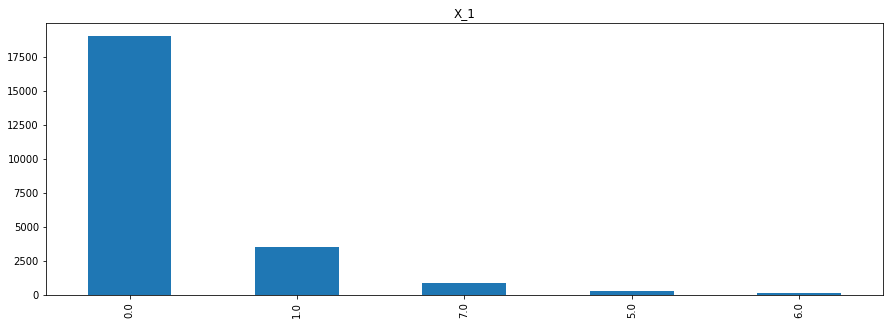

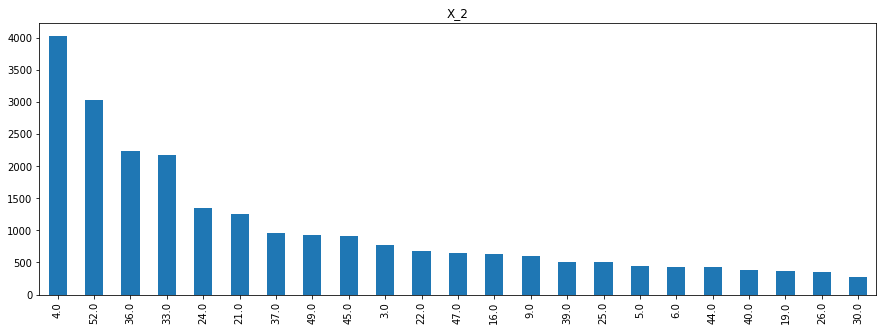

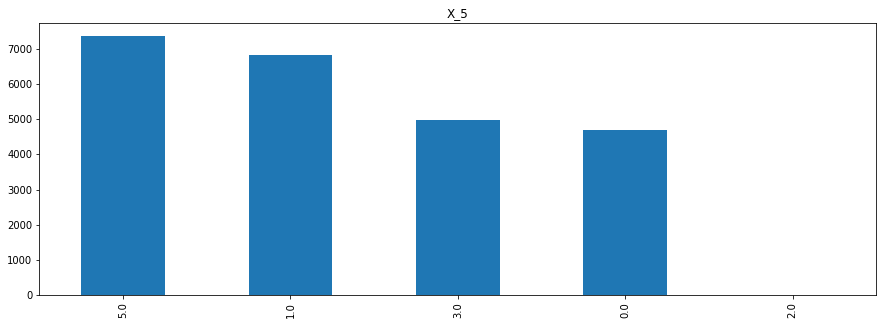

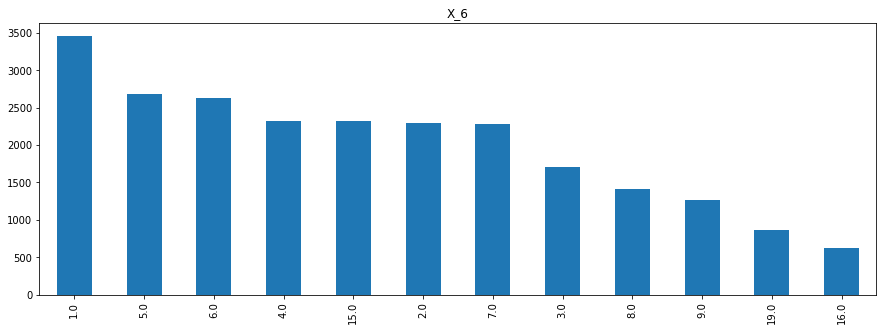

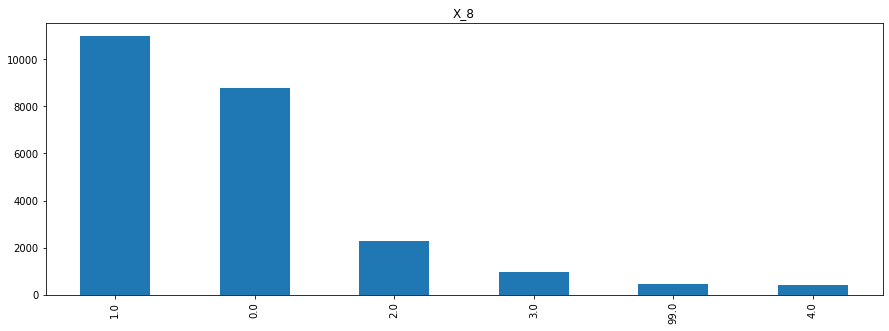

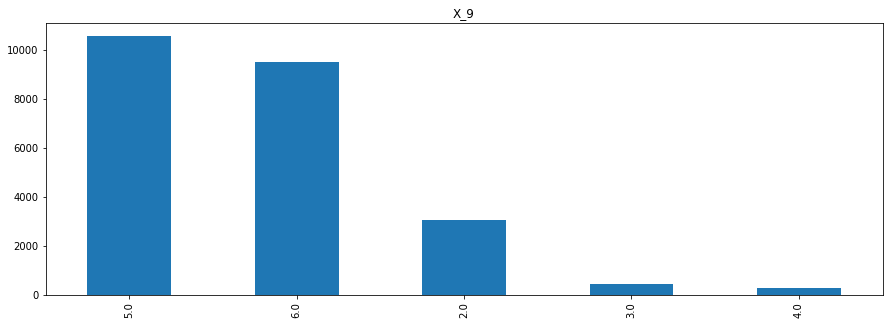

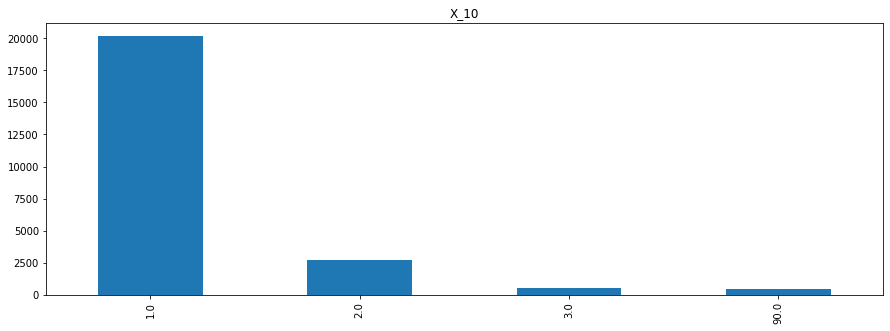

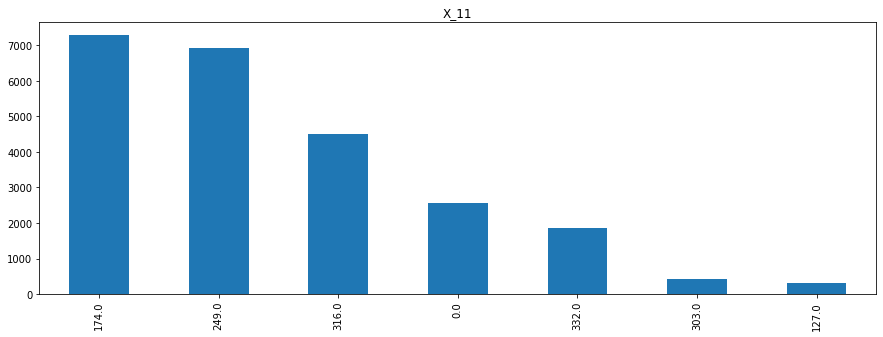

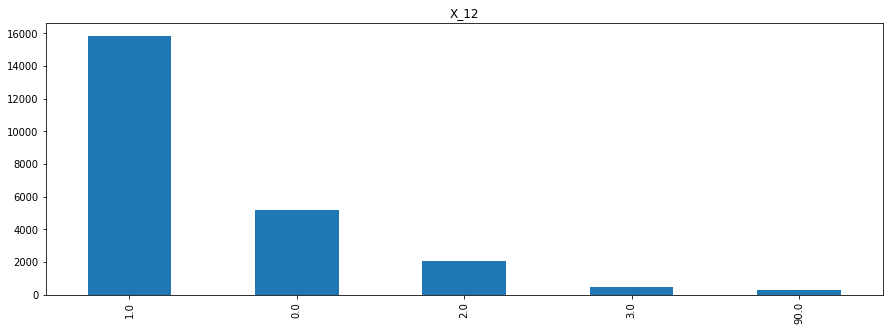

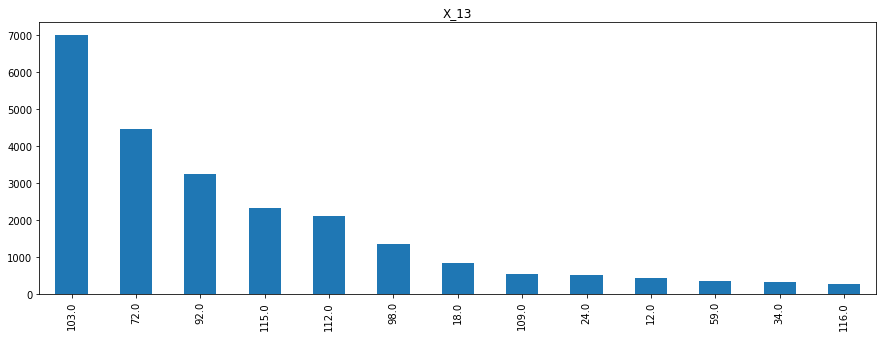

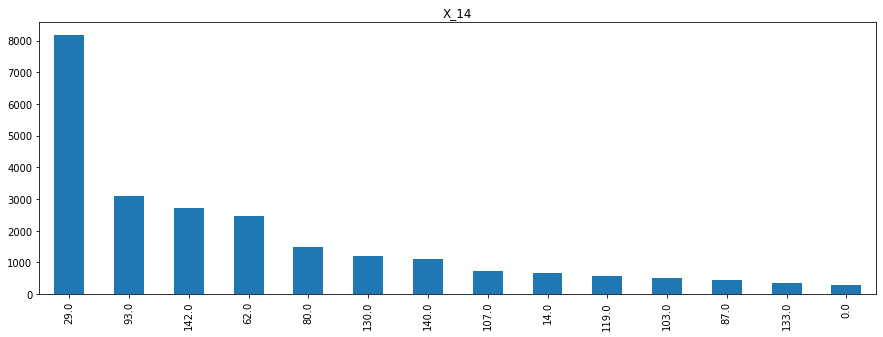

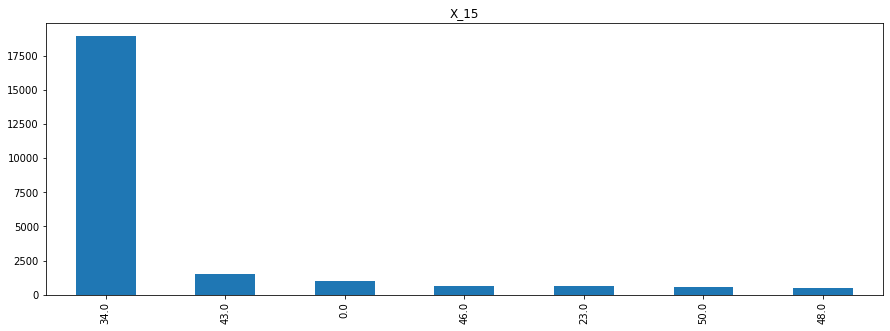

In [588]:
# Checking the value spread
for col in list(train_df.columns)[2: 14]:
    plt.figure()
    col_val= train_df[col].value_counts() 
    col_val.plot(kind= 'bar', title= col, figsize= (15, 5))

# Fitting Models

## Importing model packages

In [616]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, StratifiedKFold, cross_val_predict
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score, SCORERS
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
import warnings
warnings.filterwarnings("ignore")

## Fitting models

In [617]:
lr= LogisticRegression()
#rf= RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1, class_weight='balanced')
svc= SVC(kernel = 'sigmoid')
rf= RandomForestClassifier(max_features=1, class_weight='balanced')
# balanced attahced weight to the classes, inversely proportional to the count of their appearance in the data
gbc= GradientBoostingClassifier()

In [590]:
train_df.head(3)

,INCIDENT_ID,DATE,X_1,X_2,X_5,X_6,X_8,X_9,X_10,X_11,X_12,X_13,X_14,X_15,MULTIPLE_OFFENSE,Year,Month
0,CR_102659,04-JUL-04,0.0,36.0,1.0,5.0,1.0,6.0,1.0,174.0,1.0,92.0,29.0,50.0,0,2004,7
1,CR_189752,18-JUL-17,1.0,37.0,0.0,19.0,1.0,6.0,1.0,332.0,1.0,103.0,142.0,34.0,1,2017,7
2,CR_184637,15-MAR-17,0.0,3.0,5.0,1.0,2.0,3.0,1.0,174.0,1.0,115.0,93.0,34.0,1,2017,3


In [591]:
X_train= train_df.drop(["INCIDENT_ID", "DATE","MULTIPLE_OFFENSE"], axis= 1)
y_train= train_df.MULTIPLE_OFFENSE

In [592]:
# Random forest
kfold= StratifiedKFold(n_splits= 10, random_state= 123, shuffle= True)
cv_results_rf = cross_val_score(rf, X_train, y_train, cv= kfold, scoring= 'recall')

In [593]:
cv_results_rf.mean()
#rf.fit(X_train, y_train)
#rf.feature_importances_

0.9986835561243419

In [618]:
# SVM
kfold= StratifiedKFold(n_splits= 10, random_state= 123, shuffle= True)
cv_results_svc = cross_val_score(svc, X_train, y_train, cv= kfold, scoring= 'recall')
cv_results_svc.mean()

1.0

In [619]:
# Gradient Boosting
kfold= StratifiedKFold(n_splits= 10, random_state= 123, shuffle= True)
cv_results_gbc = cross_val_score(gbc, X_train, y_train, cv= kfold, scoring= 'recall')
cv_results_gbc.mean()

0.9983324864462757

## Predicting for test data

In [265]:
test_df.head(3)

,INCIDENT_ID,DATE,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,X_10,X_11,X_12,X_13,X_14,X_15
0,CR_195453,01-FEB-18,0,30,35,7,3,6,4,0,5,1,174,NaN,72,119,23
1,CR_103520,05-MAR-04,0,44,44,1,3,7,1,4,6,1,316,0.0,12,29,34
2,CR_196089,27-JAN-18,0,34,33,3,5,2,7,3,0,1,316,1.0,72,0,34


In [267]:
print("Shape of test data: ", test_df.shape)

Shape of test data:  (15903, 17)


In [266]:
print("Information from test data")
test_df.info()

Information from test data
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15903 entries, 0 to 15902
Data columns (total 17 columns):
INCIDENT_ID    15903 non-null object
DATE           15903 non-null object
X_1            15903 non-null int64
X_2            15903 non-null int64
X_3            15903 non-null int64
X_4            15903 non-null int64
X_5            15903 non-null int64
X_6            15903 non-null int64
X_7            15903 non-null int64
X_8            15903 non-null int64
X_9            15903 non-null int64
X_10           15903 non-null int64
X_11           15903 non-null int64
X_12           15776 non-null float64
X_13           15903 non-null int64
X_14           15903 non-null int64
X_15           15903 non-null int64
dtypes: float64(1), int64(14), object(2)
memory usage: 2.1+ MB


In [268]:
test_df.describe(include= 'all')

,INCIDENT_ID,DATE,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,X_10,X_11,X_12,X_13,X_14,X_15
count,15903,15903,15903.000000,15903.000000,15903.000000,15903.000000,15903.000000,15903.000000,15903.000000,15903.000000,15903.000000,15903.000000,15903.000000,15776.000000,15903.000000,15903.000000,15903.000000
unique,15903,7939,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,CR_158637,13-SEP-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,0.468088,24.722631,24.575049,4.284223,2.448469,6.084890,4.862605,0.986732,4.908759,1.241212,206.954097,0.972236,85.191096,72.218575,33.422625
std,NaN,NaN,1.412112,15.228841,15.127451,2.974584,1.963372,4.451117,3.854550,1.471274,1.374677,0.841804,93.107783,0.876669,27.493192,43.438227,8.314284
min,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,NaN,NaN,0.000000,7.000000,8.000000,2.000000,1.000000,3.000000,2.000000,0.000000,5.000000,1.000000,174.000000,1.000000,72.000000,29.000000,34.000000
50%,NaN,NaN,0.000000,24.000000,24.000000,4.000000,3.000000,5.000000,4.000000,1.000000,5.000000,1.000000,249.000000,1.000000,98.000000,62.000000,34.000000
75%,NaN,NaN,0.000000,36.000000,35.000000,6.000000,5.000000,8.000000,7.000000,1.000000,6.000000,1.000000,249.000000,1.000000,103.000000,107.000000,34.000000


In [269]:
test_df["Year"]= pd.DatetimeIndex(test_df.DATE).year
test_df["Month"]= pd.DatetimeIndex(test_df.DATE).month
test_df.head(3)

,INCIDENT_ID,DATE,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,X_10,X_11,X_12,X_13,X_14,X_15,Year,Month
0,CR_195453,01-FEB-18,0,30,35,7,3,6,4,0,5,1,174,NaN,72,119,23,2018,2
1,CR_103520,05-MAR-04,0,44,44,1,3,7,1,4,6,1,316,0.0,12,29,34,2004,3
2,CR_196089,27-JAN-18,0,34,33,3,5,2,7,3,0,1,316,1.0,72,0,34,2018,1


In [274]:
print(" Missing value count")
test_df.isna().sum()/ len(test_df)

 Missing value count


INCIDENT_ID    0.000000
DATE           0.000000
X_1            0.000000
X_2            0.000000
X_3            0.000000
X_4            0.000000
X_5            0.000000
X_6            0.000000
X_7            0.000000
X_8            0.000000
X_9            0.000000
X_10           0.000000
X_11           0.000000
X_12           0.007986
X_13           0.000000
X_14           0.000000
X_15           0.000000
Year           0.000000
Month          0.000000
dtype: float64

In [275]:
# imputing missing values
test_df.X_12.fillna(test_df.X_12.mode()[0], inplace= True)

In [594]:
test_df.head(3)

,INCIDENT_ID,DATE,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,X_10,X_11,X_12,X_13,X_14,X_15,Year,Month
0,CR_195453,01-FEB-18,0,30,35,7,3,6,4,0,5,1,174,1.0,72,119,23,2018,2
1,CR_103520,05-MAR-04,0,44,44,1,3,7,1,4,6,1,316,0.0,12,29,34,2004,3
2,CR_196089,27-JAN-18,0,34,33,3,5,2,7,3,0,1,316,1.0,72,0,34,2018,1


In [ ]:
# Checking the value spread
for col in list(train_df.columns)[2: 14]:
    plt.figure()
    col_val= train_df[col].value_counts() 
    col_val.plot(kind= 'bar', title= col, figsize= (15, 5))

In [596]:
inp_df= test_df.drop(['INCIDENT_ID', 'DATE','X_3', 'X_4', 'X_7'], axis= 1)
inp_df.head(3)

,X_1,X_2,X_5,X_6,X_8,X_9,X_10,X_11,X_12,X_13,X_14,X_15,Year,Month
0,0,30,3,6,0,5,1,174,1.0,72,119,23,2018,2
1,0,44,3,7,4,6,1,316,0.0,12,29,34,2004,3
2,0,34,5,2,3,0,1,316,1.0,72,0,34,2018,1


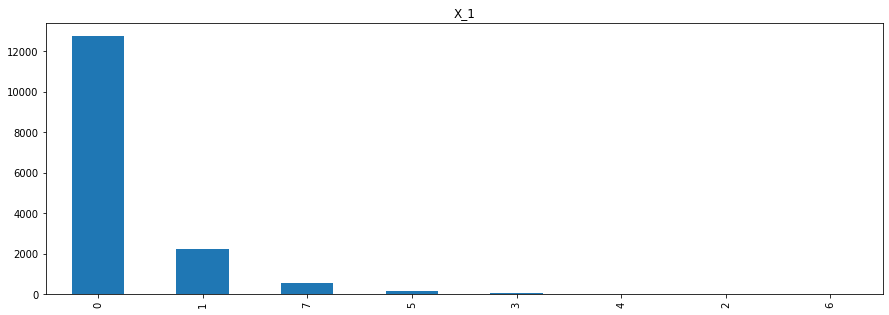

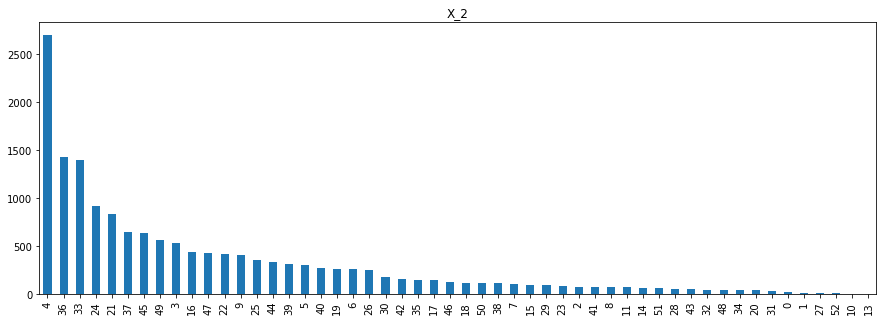

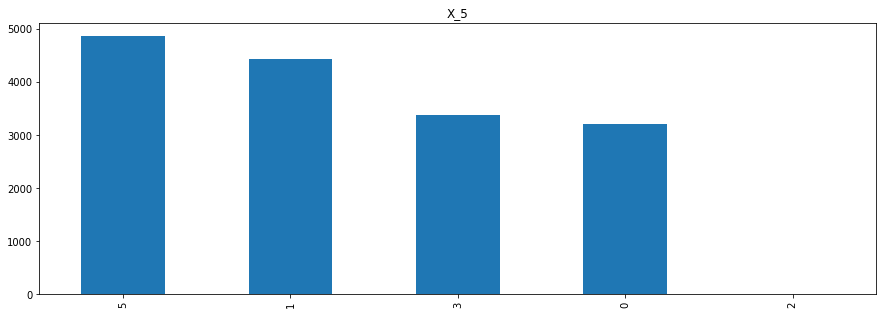

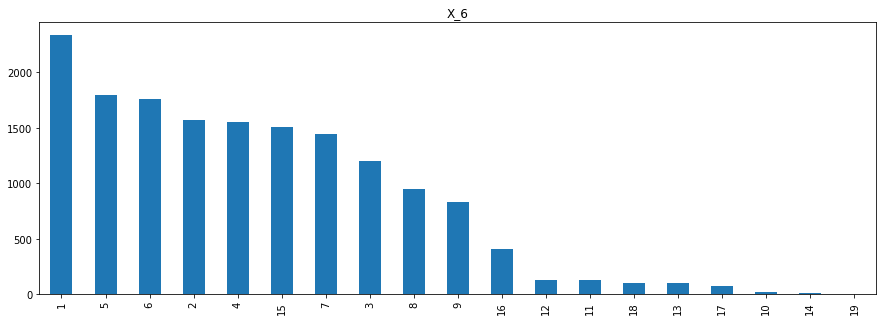

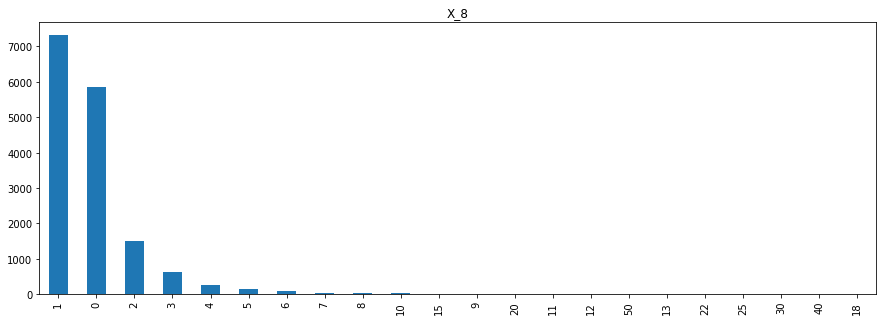

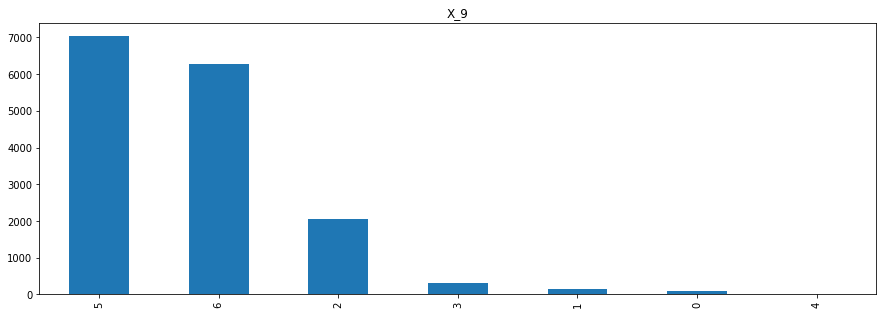

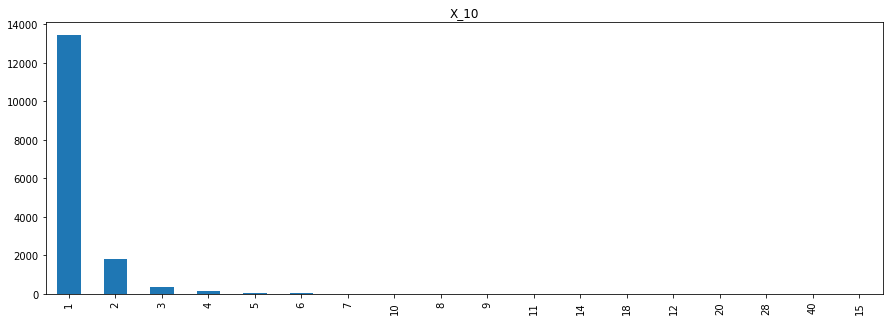

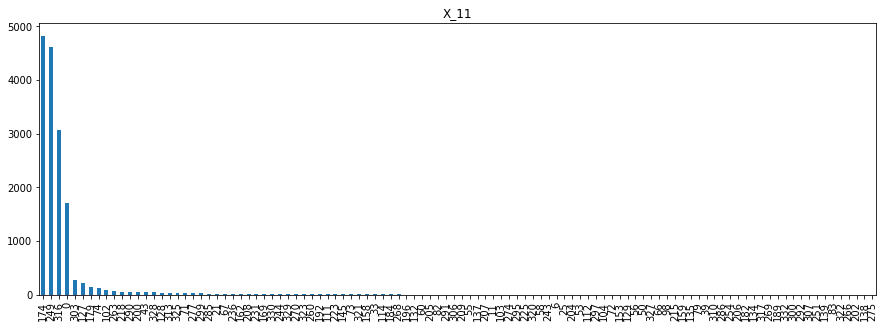

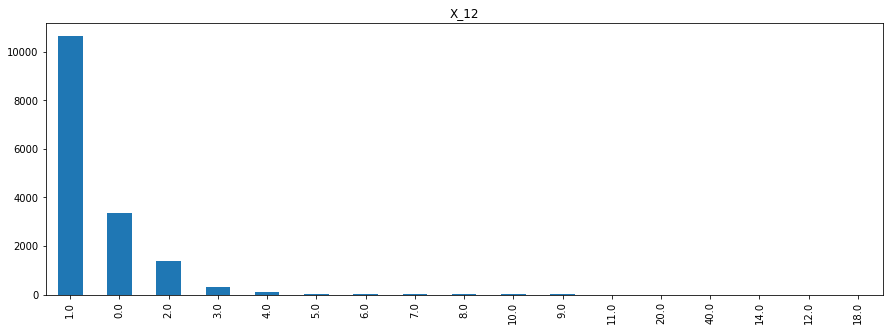

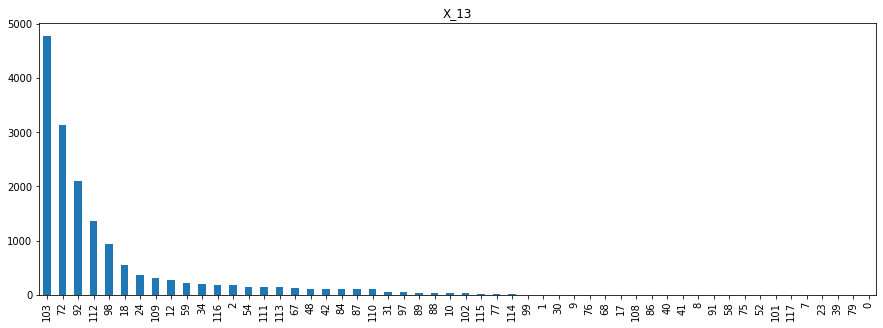

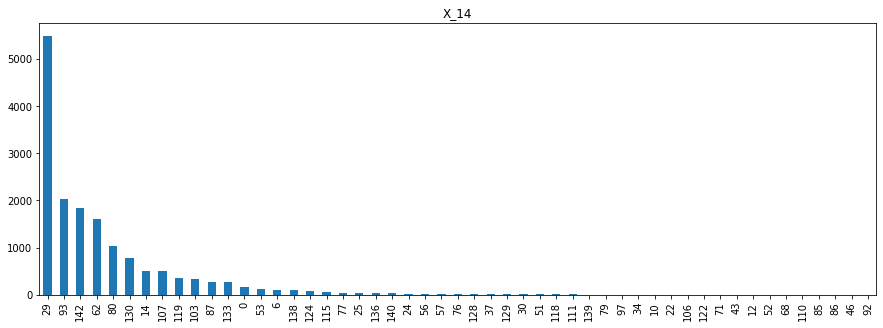

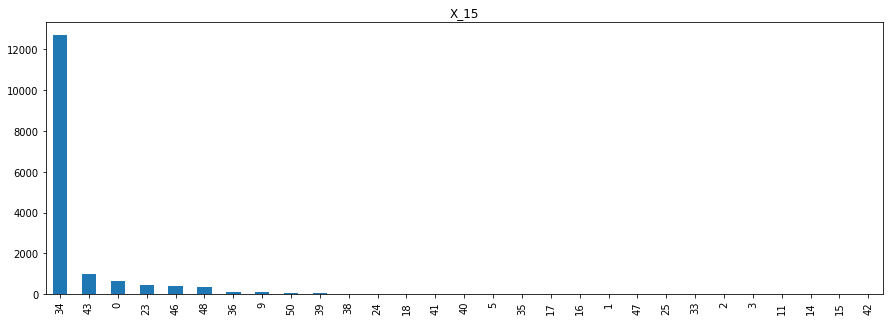

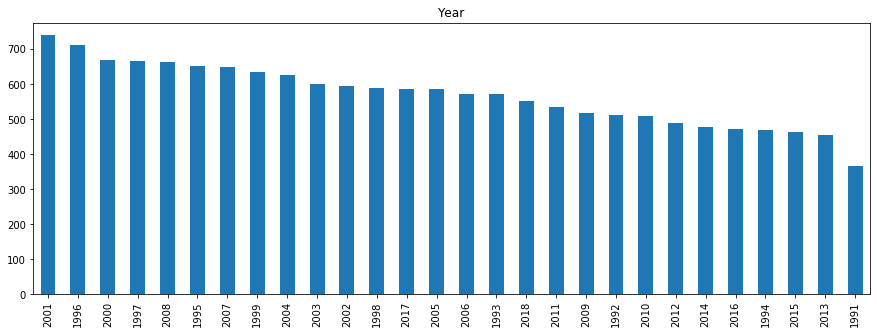

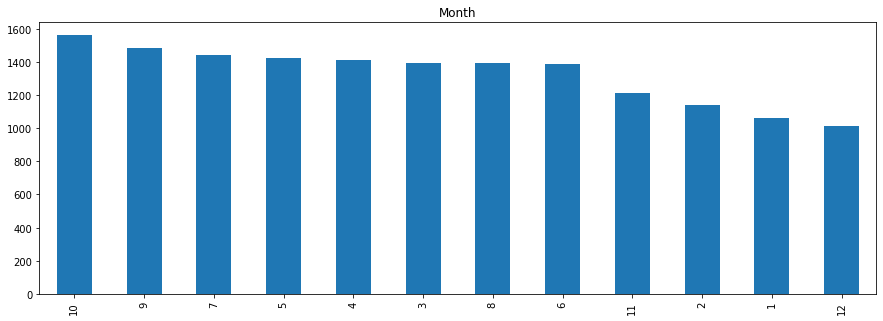

In [597]:
# Checking the value spread
for col in list(inp_df.columns):
    plt.figure()
    col_val= inp_df[col].value_counts() 
    col_val.plot(kind= 'bar', title= col, figsize= (15, 5))

The spread of test data is quite similar to that of train. So we do the replace of values on similar way.

In [601]:
# to form a dataframe of value counts
lowval2= pd.DataFrame(index= list(range(0, 128) ), columns= inp_df.columns[:-2])
for i in list(lowval2.columns):
    x= pd.DataFrame(inp_df[i].value_counts() )
    
    # to get all values below threshold
    s= pd.DataFrame(x[x.loc[:, i]<250].index.sort_values(ascending= False))
    lowval2.loc[:,i]= s[0]
#lowval2.head(3)

# Replacing
for col in list(lowval.columns):
    inp_df[col].replace([lowval2[col]], lowval2[col][0], inplace= True)    

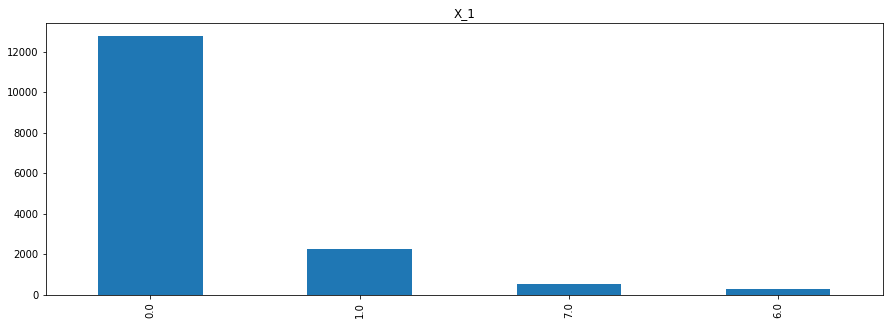

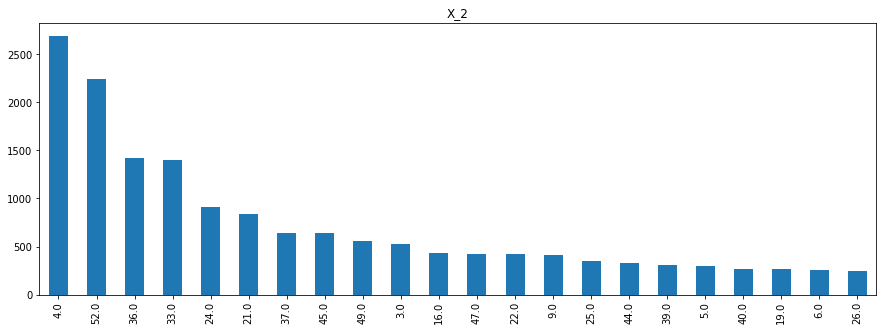

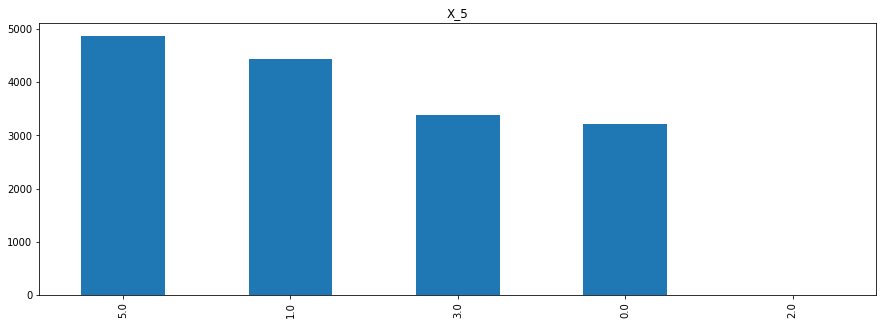

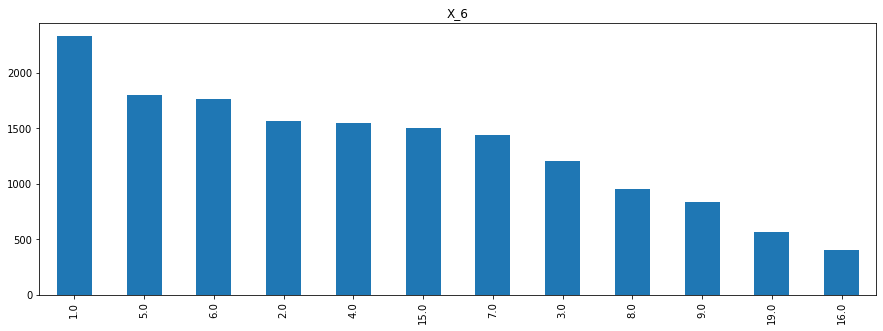

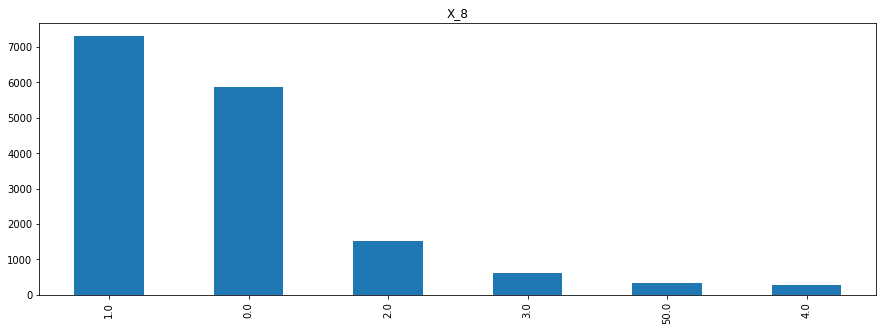

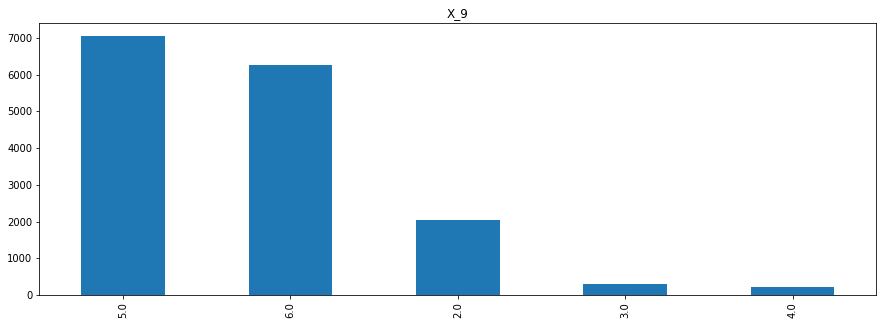

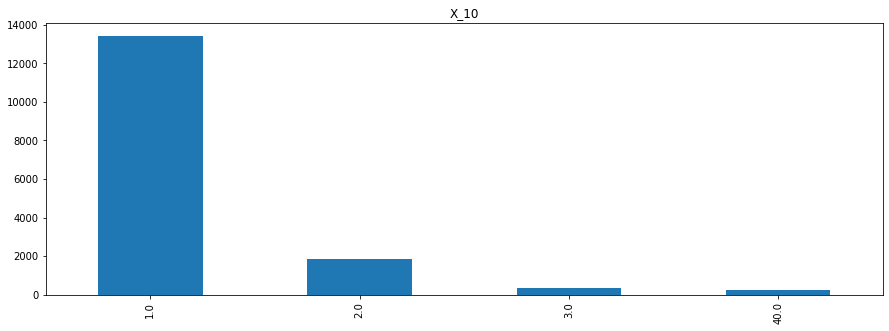

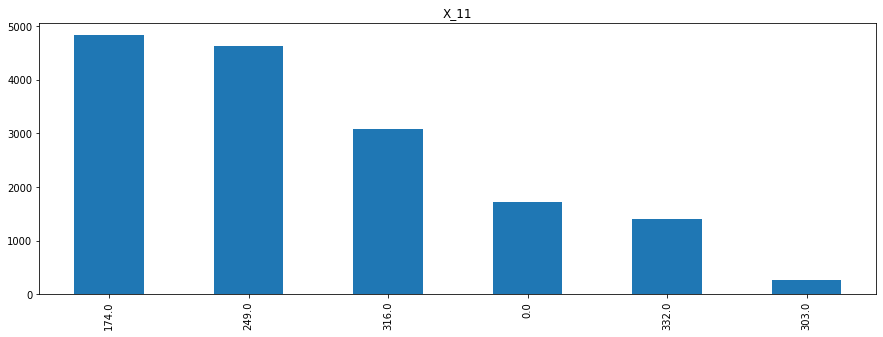

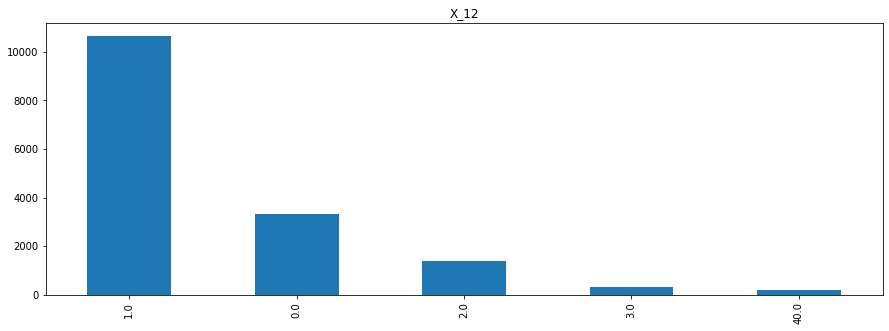

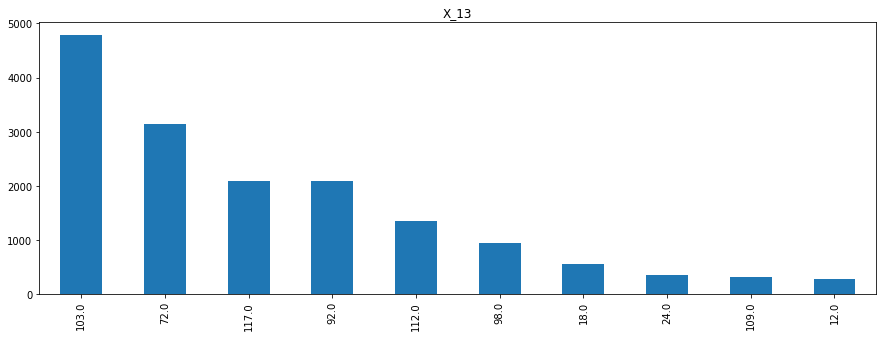

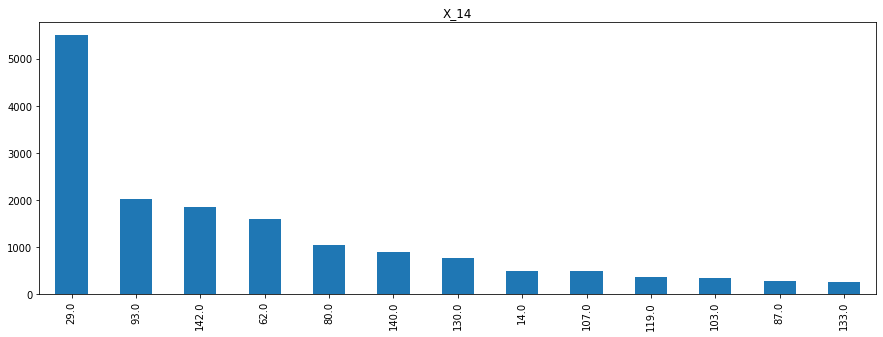

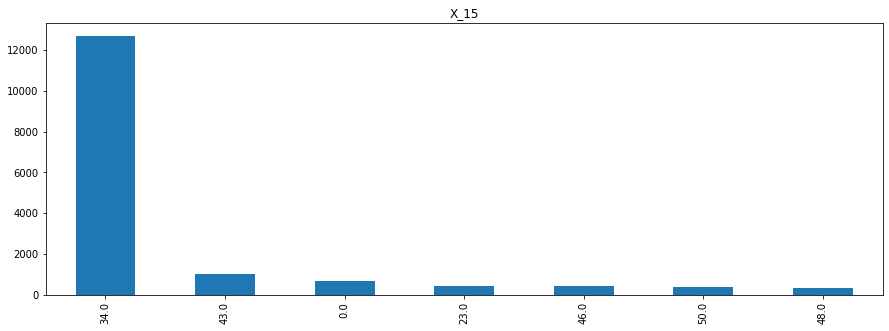

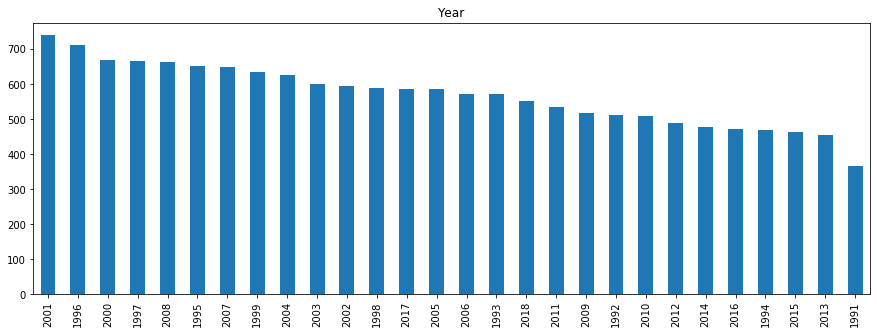

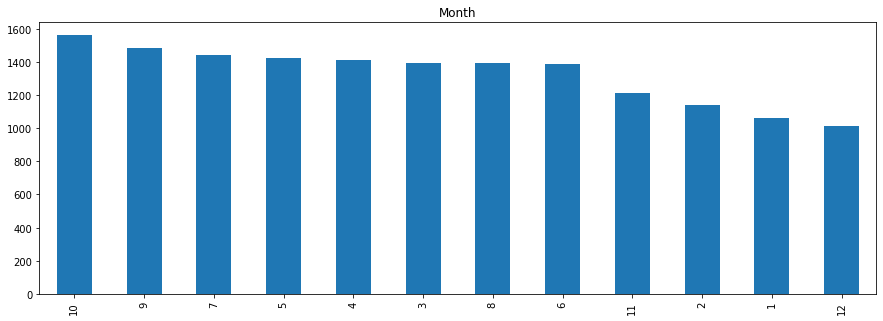

In [602]:
# Checking the value spread
for col in list(inp_df.columns):
    plt.figure()
    col_val= inp_df[col].value_counts() 
    col_val.plot(kind= 'bar', title= col, figsize= (15, 5))

 Random forest model fit

In [603]:
rf.fit(X_train, y_train)
pred_rf= rf.predict(inp_df)
pred_rf

array([1, 1, 1, ..., 1, 1, 1], dtype=int64)

In [604]:
subm= test_df.loc[:, 'INCIDENT_ID']
subm_rf= pd.concat([subm, pd.DataFrame(pred_rf)], axis= 1)

In [605]:
subm_rf.columns= ['INCIDENT_ID', 'MULTIPLE_OFFENSE']
subm_rf.head(3)

,INCIDENT_ID,MULTIPLE_OFFENSE
0,CR_195453,1
1,CR_103520,1
2,CR_196089,1


In [606]:
subm_rf.MULTIPLE_OFFENSE.value_counts()

1    15219
0      684
Name: MULTIPLE_OFFENSE, dtype: int64

In [610]:
subm_rf.to_csv(f'{filepath}\Submission1.csv', index= False)

 SVM

In [613]:
svc.fit(X_train, y_train)
pred_svc= svc.predict(inp_df)
pred_svc

array([1, 1, 1, ..., 1, 1, 1], dtype=int64)

In [614]:
subm_svc= pd.concat([subm, pd.DataFrame(pred_svc)], axis= 1)
subm_svc.columns= ['INCIDENT_ID', 'MULTIPLE_OFFENSE']
subm_svc.head(3)

,INCIDENT_ID,MULTIPLE_OFFENSE
0,CR_195453,1
1,CR_103520,1
2,CR_196089,1


In [615]:
subm_svc.MULTIPLE_OFFENSE.value_counts()

1    15903
Name: MULTIPLE_OFFENSE, dtype: int64

Gradient Boosting

In [620]:
gbc.fit(X_train, y_train)
pred_gbc= gbc.predict(inp_df)
pred_gbc

array([1, 1, 1, ..., 1, 1, 1], dtype=int64)

In [621]:
subm_gbc= pd.concat([subm, pd.DataFrame(pred_gbc)], axis= 1)
subm_gbc.columns= ['INCIDENT_ID', 'MULTIPLE_OFFENSE']
subm_gbc.head(3)

,INCIDENT_ID,MULTIPLE_OFFENSE
0,CR_195453,1
1,CR_103520,1
2,CR_196089,1


In [622]:
subm_gbc.MULTIPLE_OFFENSE.value_counts()

1    15119
0      784
Name: MULTIPLE_OFFENSE, dtype: int64

In [624]:
subm_gbc.to_csv(f'{filepath}\Submission2.csv', index= False)

In [625]:
from sklearn.dummy import DummyClassifier

In [626]:
# SVM
dcl= DummyClassifier(strategy='most_frequent')
kfold= StratifiedKFold(n_splits= 10, random_state= 123, shuffle= True)
cv_results_dc = cross_val_score(dcl, X_train, y_train, cv= kfold, scoring= 'recall')
cv_results_dc.mean()

1.0